In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


In [20]:
data_types = {
    'PD_DESC': 'category',
    'OFNS_DESC': 'category',
    'LAW_CODE': 'category',
    'LAW_CAT_CD': 'category',
    'ARREST_BORO': 'category',
    'ARREST_PRECINCT': 'category',
    'JURISDICTION_CODE': 'category',
    'AGE_GROUP': 'category',
    'PERP_SEX': 'category',
    'PERP_RACE': 'category'
}
df = pd.read_csv('NYPD_arrest_data_2021-2023.csv', dtype=data_types)
df['ARREST_DATE'] = pd.to_datetime(df['ARREST_DATE'])

In [21]:
df.head()

,ARREST_DATE,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,Lon_Lat
0,2022-10-16,CRIMINAL MIS 2 & 3,121.0,CRIMINAL MISCHIEF & RELATED OF,PL 1450502,Felony,Brooklyn,76,2.0,25-44,Male,BLACK,40.676869,-74.006640,POINT (-74.00664 40.676869)
1,2022-04-12,"CONTROLLED SUBSTANCE,INTENT TO",117.0,DANGEROUS DRUGS,PL 2201602,Felony,Manhattan,14,0.0,18-24,Male,BLACK,40.753533,-73.994537,POINT (-73.9945368920152 40.7535327012632)
2,2022-03-19,"LARCENY,PETIT FROM OPEN AREAS,",341.0,PETIT LARCENY,PL 1552500,Misdemeanor,Brooklyn,60,0.0,25-44,Male,WHITE,40.582620,-73.986223,POINT (-73.986223 40.58262)
3,2022-08-24,"LARCENY,GRAND FROM OPEN AREAS, UNATTENDED",109.0,GRAND LARCENY,PL 1553001,Felony,Brooklyn,84,0.0,18-24,Male,WHITE HISPANIC,40.690115,-73.989019,POINT (-73.989019 40.690115)
4,2022-01-07,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306501,Felony,Manhattan,24,2.0,25-44,Male,BLACK,40.796074,-73.967067,POINT (-73.9670667458109 40.7960743128304)


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412713 entries, 0 to 412712
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ARREST_DATE        412713 non-null  datetime64[ns]
 1   PD_DESC            412713 non-null  category      
 2   KY_CD              412713 non-null  float64       
 3   OFNS_DESC          412713 non-null  category      
 4   LAW_CODE           412713 non-null  category      
 5   LAW_CAT_CD         412713 non-null  category      
 6   ARREST_BORO        412713 non-null  category      
 7   ARREST_PRECINCT    412713 non-null  category      
 8   JURISDICTION_CODE  412713 non-null  category      
 9   AGE_GROUP          412713 non-null  category      
 10  PERP_SEX           412713 non-null  category      
 11  PERP_RACE          412713 non-null  category      
 12  Latitude           412713 non-null  float64       
 13  Longitude          412713 non-null  float64 

### Heatmap

In [24]:
label_encoders = {}
for column in df.select_dtypes(include=['category', 'object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])


/var/folders/18/920vt1r90t39q35zb6glj_6h0000gn/T/ipykernel_943/2993002912.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()
/var/folders/18/920vt1r90t39q35zb6glj_6h0000gn/T/ipykernel_943/2993002912.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df.corr(), dtype=bool))


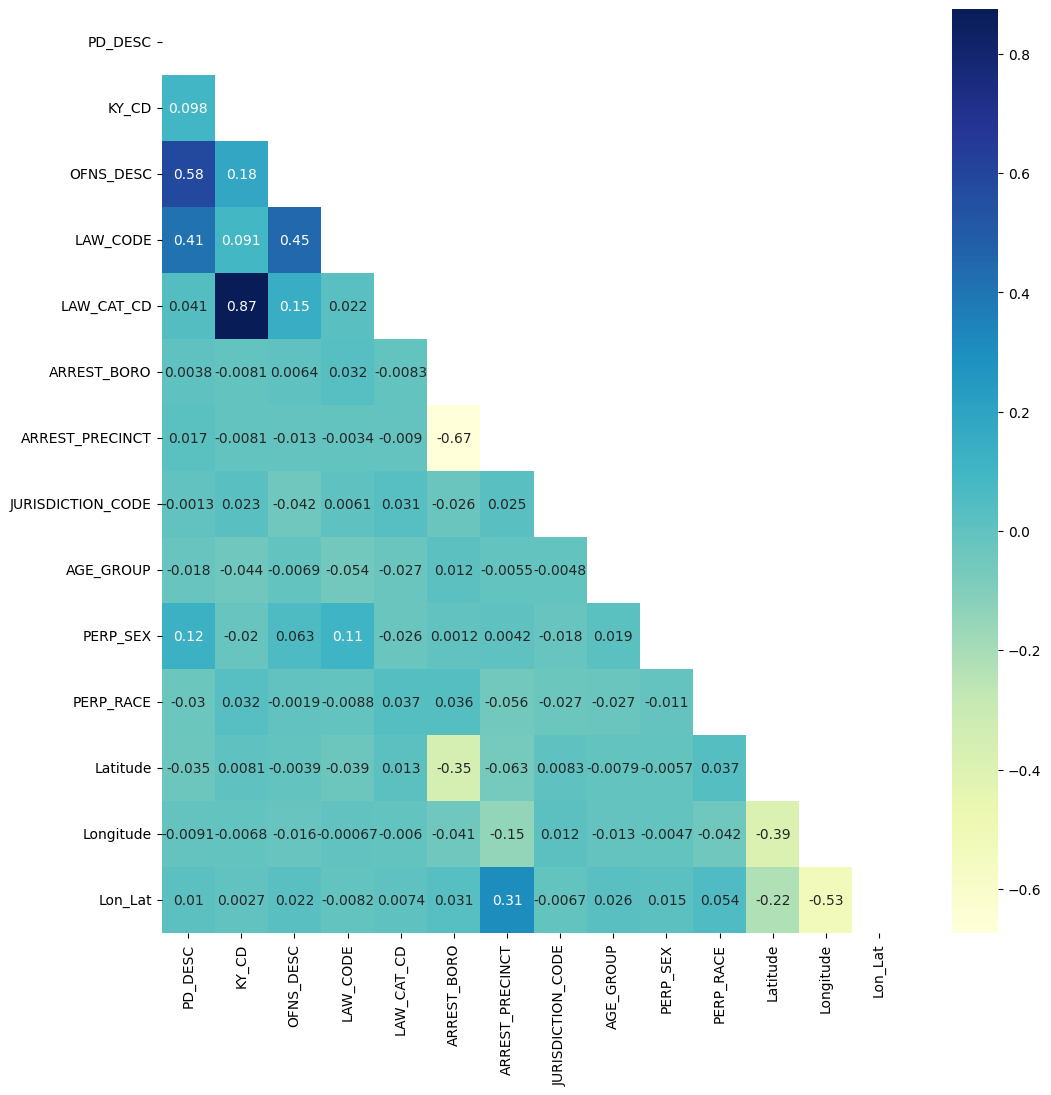

In [38]:
corr = df.corr()
plt.figure(figsize=(12,12))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(corr, cmap ='YlGnBu', annot=True, mask = mask, annot_kws={'size':10})
plt.savefig('Heatmap.png')

The heatmap shows a strong correlation (0.87) between LAW_CAT_CD and OFNS_DESC. Indicatin that the offense description is highly predictive of the law category code. intuitivly this makes sense since the type of offense would directly influence whether it is categorized as a misdemeanor, felony, etc.

Moderate correlation (0.45) between LAW_CAT_CD and LAW_CODE. This suggests that the specific law code is also an important predictor, though not as strong as the offense description.

KY_CD (0.15): Indicates a weak relationship.

AGE_GROUP (0.022): Shows a very weak correlation.

PERP_RACE (0.054): Also shows a weak correlation.

Latitude (0.054) and Longitude (0.31): Both have relatively low correlations.

In [47]:
unique_offenses = df['OFNS_DESC'].unique()
print(unique_offenses)


[11 13 54 25 59 43  6 14 61 19 21 46 58 55 48 30 64 36 12  8 26 45 57  5
 52 42 62  2 38  0 56  7 40 49 22 28 31 50  4 29 23  3 17 60 37 10 34  9
 24 27 44 18 33 47 15 32 39 53 51 35 16 63 41  1 20]


In [45]:
features = ['ARREST_DATE', 'ARREST_BORO', 'ARREST_PRECINCT', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'Latitude', 'Longitude']
target = 'LAW_CAT_CD'
X = df[features]
y = df[target]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
scaler = StandardScaler()
#ARREST_DATE needs to be converted to a numerical value
X_train['ARREST_DATE'] = X_train['ARREST_DATE'].astype(np.int64)
X_test['ARREST_DATE'] = X_test['ARREST_DATE'].astype(np.int64)

X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

### Logistic Regression

In [28]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [29]:
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.50      0.13      0.21     36498
           1       0.56      0.90      0.69     45384
           2       0.00      0.00      0.00        98
           3       0.00      0.00      0.00       134
           4       0.00      0.00      0.00       429

    accuracy                           0.55     82543
   macro avg       0.21      0.21      0.18     82543
weighted avg       0.53      0.55      0.47     82543



/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision is the proportion of true positive predictions among all positive predictions
Recall is the proportion of true positive predictions among all actual positives
The F1-Score is the harmonic mean of precision and recall
The performance metrics indicate a significant issue with class imbalance and model bias towards the majority class.

### Class 0: 
Accuracy: Of all the predictions only 50% were correct
Recall: Only 13% of actual Class 0 instances are correctly predicted as Class 0
F1 Score: The F1-Score of 0.21 indicates poor performance, as it balances both precision and recall

### Class 1:
Accuracy: Out of all instances predicted as Class 1, 56% are actually Class 1
Recall: The model correctly predicted this class 90% of the time
F1 Score: 69% is a reasonably high score but inconclusive due to the class imbalance

### Class 2:
The model fails to predict this correctly, indicating that it doesn't recognize this class at all

### Class 3,4, and 5:
The model fails to predict these classes correctly, indicating that it  doesn't recognize these classes at all

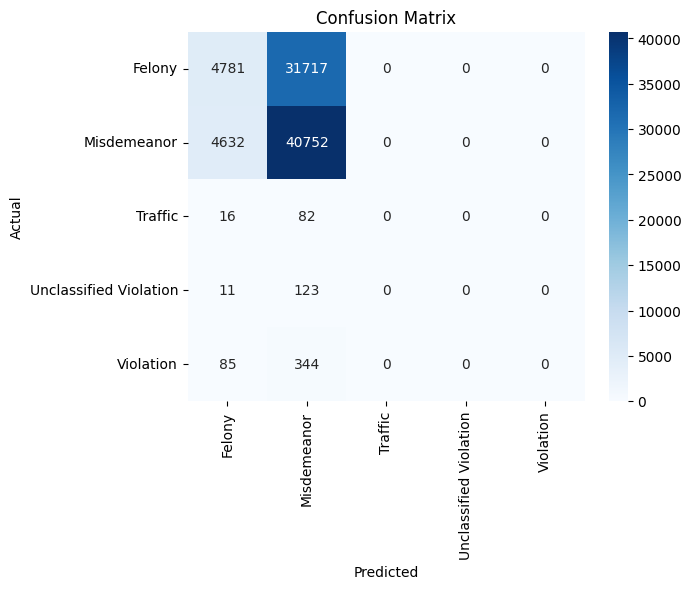

In [30]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoders[target].classes_, yticklabels=label_encoders[target].classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Handling class imbalance using SMOTE

In [31]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [32]:
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)


Accuracy: 0.23
              precision    recall  f1-score   support

           0       0.46      0.13      0.20     36498
           1       0.59      0.31      0.41     45384
           2       0.00      0.26      0.00        98
           3       0.01      0.90      0.02       134
           4       0.01      0.55      0.02       429

    accuracy                           0.23     82543
   macro avg       0.22      0.43      0.13     82543
weighted avg       0.53      0.23      0.31     82543



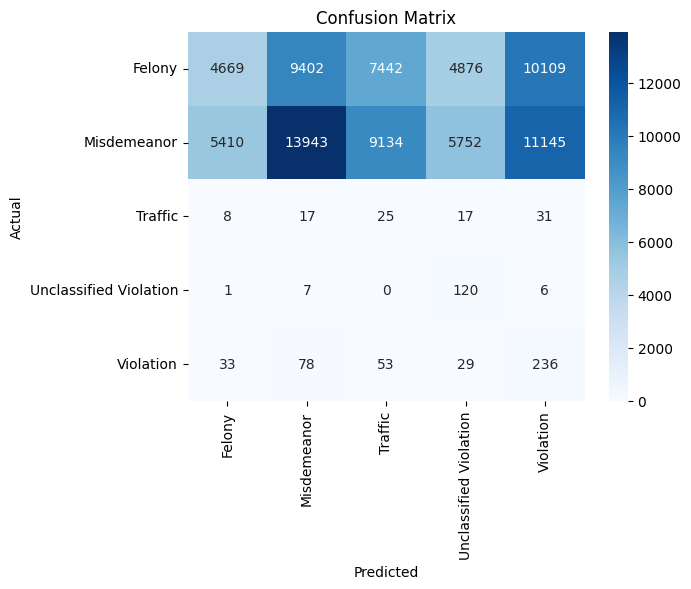

In [33]:

# Initialize the logistic regression model
logreg = LogisticRegression(max_iter=10000, random_state=42)

# Train the model
logreg.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred = logreg.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoders[target].classes_, yticklabels=label_encoders[target].classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [34]:
print('Train:',logreg.score(X_train, y_train))
print('Test:',logreg.score(X_test,y_test))

Train: 0.17717539449374564
Test: 0.17784669808463469


/usr/local/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### Defining Pipeline

In [41]:
# def results(model, X, y):
#     y_pred = model.predict(X)
#     cm = confusion_matrix(y, y_pred, labels= model.classes_)
#     disp = ConfusionMatrixDisplay(cm, display_labels = model.classes_)
#     print(f'Accuracy Score: {accuracy_score(y,y_pred)}')
#     print(f'Precision Score: {precision_score(y,y_pred)}')
#     print(f'Recall Score: {recall_score(y,y_pred)}')
#     print(f'F1 Score: {f1_score(y,y_pred)}')

#     #ROC Curve
#     if hasattr(model, 'decision_function'):
#         if hasattr(model, 'predict_log_proba'):
#             #For Random Forest Classifier
#             scores = model.predict_log_proba(X)[:,1]
#         else:
#             #For SVM
#             scores = model_decision_function(X)
#         #Plotting ROC Curve
#         fpr, tpr, threshold = roc_curve(y, scores)
#         roc_auc = auc(fpr, tpr)
#         plt.figure()
#         plt.plot(fpr,tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
#         plt.plot([0,1], [0,1], 'k--')
#         plt.xlim([0.0, 1.0])
#         plt.ylim([0.0,1.05])
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title('R.O.I Curve')
#         plt.legend(loc = 'lower right')
#         plt.show

### Model Results Function

In [43]:
def results(model, X, y):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    print(f'Accuracy Score: {accuracy_score(y, y_pred):.2f}')
    print(f'Precision Score (weighted): {precision_score(y, y_pred, average="weighted"):.2f}')
    print(f'Recall Score (weighted): {recall_score(y, y_pred, average="weighted"):.2f}')
    print(f'F1 Score (weighted): {f1_score(y, y_pred, average="weighted"):.2f}')

    # ROC Curve
    if hasattr(model, 'decision_function') or hasattr(model, 'predict_proba'):
        # Check if model supports decision_function or predict_proba
        if hasattr(model, 'predict_proba'):
            # For models that provide probability estimates (e.g., Random Forest)
            y_score = model.predict_proba(X)
        elif hasattr(model, 'decision_function'):
            # For models that provide decision function (e.g., SVM)
            y_score = model.decision_function(X)

        # If it's a multi-class problem, compute ROC curve and AUC for each class
        if len(model.classes_) > 2:
            # Binarize the output
            from sklearn.preprocessing import label_binarize
            y_bin = label_binarize(y, classes=model.classes_)
            n_classes = y_bin.shape[1]

            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
            fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
            roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

            plt.figure()
            plt.plot(fpr["micro"], tpr["micro"],
                     label='micro-average ROC curve (area = {0:0.2f})'
                           ''.format(roc_auc["micro"]))
            for i in range(n_classes):
                plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                              ''.format(i, roc_auc[i]))

            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc='lower right')
            plt.show()

        else:
            fpr, tpr, _ = roc_curve(y, y_score[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.figure()
            plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc='lower right')
            plt.show()
    else:
        print("The model does not support decision_function or predict_proba.")

/usr/local/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


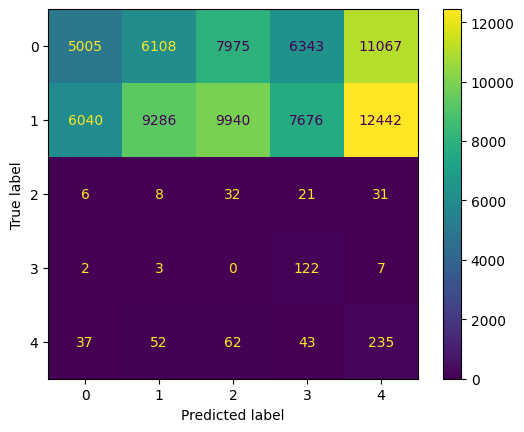

Accuracy Score: 0.18
Precision Score (weighted): 0.53
Recall Score (weighted): 0.18
F1 Score (weighted): 0.26


/usr/local/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


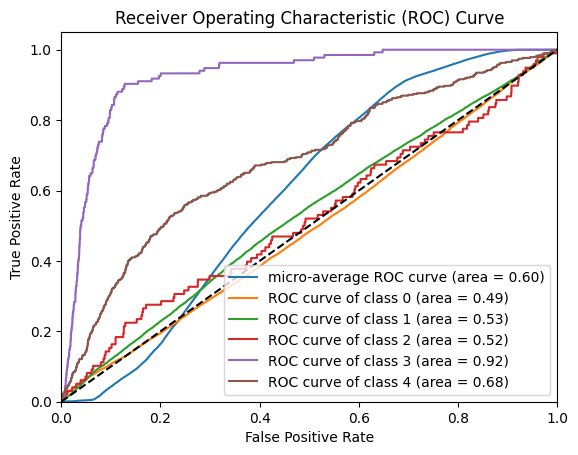

In [44]:
# Example usage with a logistic regression model
logreg = LogisticRegression(max_iter=10000, random_state=42)
logreg.fit(X_train_smote, y_train_smote)
results(logreg, X_test, y_test)


### Pipeline Creation

### Decision Trees

### Gradient Boosting Machines (GBM)

### Support Vector Machines (SVM)